<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy as sp; from scipy.io import wavfile; from scipy import signal
from scipy.signal import windows, freqz
import pydub
from pydub import AudioSegment
import statsmodels.tsa.stattools

The sampling rate of the audio files.

In [3]:
sr = 44100

Little function used to write to audio files.

In [4]:
def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

# Get Data

In [5]:
df_a = pd.read_pickle("./acoustic_df.pkl")

In [6]:
E = np.array(df_a['E'].dropna()); Em = np.array(df_a['E_mute'].dropna()); 
A = np.array(df_a['A'].dropna()); Am = np.array(df_a['A_mute'].dropna()); 
D = np.array(df_a['D'].dropna()); Dm = np.array(df_a['D_mute'].dropna()); 
G = np.array(df_a['G'].dropna()); Gm = np.array(df_a['G_mute'].dropna()); 
B = np.array(df_a['B'].dropna()); Bm = np.array(df_a['B_mute'].dropna()); 
Eh = np.array(df_a['Eh'].dropna()); Ehm = np.array(df_a['Eh_mute'].dropna()); 

# Tapering

Apply a few filters to the time series of the form

$$L[X_t] = \sum_{u=-\infty}^\infty g_u X_{t-u} $$

In [7]:
def remove_mean(arr):
    return np.mean(arr), arr-np.mean(arr)

_, E_d = remove_mean(E)
_, Em_d = remove_mean(Em)
_, A_d = remove_mean(A)
_, Am_d = remove_mean(Am)
_, D_d = remove_mean(D)
_, Dm_d = remove_mean(Dm)
_, G_d = remove_mean(G)
_, Gm_d = remove_mean(Gm)
_, B_d = remove_mean(B)
_, Bm_d = remove_mean(Bm)
_, Eh_d = remove_mean(Eh)
_, Ehm_d = remove_mean(Ehm)

## Hanning Taper

In [8]:
def hanning_taper(arr):
    return arr*signal.hann(len(arr))

In [9]:
E_han = hanning_taper(E_d)
Em_han = hanning_taper(Em_d)

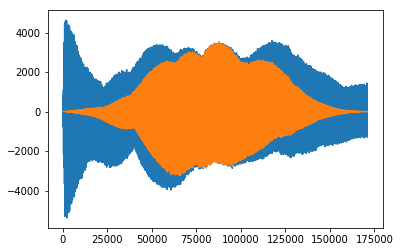

In [10]:
plt.plot(E_d)
plt.plot(hanning_taper(E_d))

In [11]:
f_E, Pxx_den_E = signal.periodogram(E_d, sr)
f_E_han, Pxx_den_E_han = signal.periodogram(E_han, sr)

f_Em, Pxx_den_Em = signal.periodogram(Em_d, sr)
f_Em_han, Pxx_den_Em_han = signal.periodogram(Em_han, sr)

### Plot Periodogram

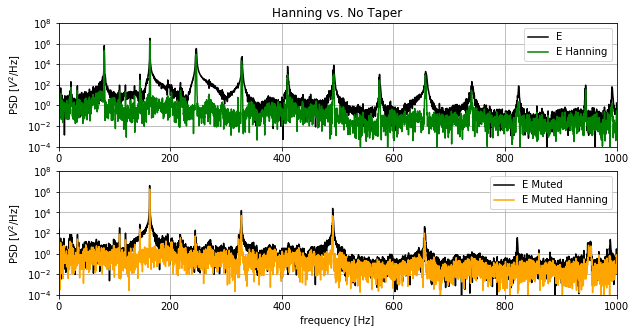

In [12]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

ax[0].semilogy(f_E, Pxx_den_E, label='E', c='k')
ax[0].semilogy(f_E_han, Pxx_den_E_han, label='E Hanning', c='green')

ax[1].semilogy(f_Em, Pxx_den_Em, label='E Muted', c='k')
ax[1].semilogy(f_Em_han, Pxx_den_Em_han, label='E Muted Hanning', c='orange')

ax[1].set_xlabel('frequency [Hz]')
[a.set_ylabel('PSD [$V^2$/Hz]') for a in ax.ravel()]
[a.set_xlim(0,1000) for a in ax.ravel()]
[a.set_ylim(10**-4, 10**8) for a in ax.ravel()]
[a.legend() for a in ax.ravel()]
[a.grid() for a in ax.ravel()]


ax[0].set_title('Hanning vs. No Taper')


plt.savefig('test_plot.png', dpi=300)
plt.show()

Conclusion: Hanning Window more effective when spectral range is more varying (more peaks).

## DPSS Taper

Experiment: How Narrow does the DPSS need to be such that neighbouring peaks become smeared out. First lets make our time series shorter

In [13]:
red = 10; NN=500
sr = 44100/red

E_sht = E_d[0::red][0:NN]
A_sht = A_d[0::red][0:NN]
D_sht = D_d[0::red][0:NN]
G_sht = G_d[0::red][0:NN]
B_sht = B_d[0::red][0:NN]
Eh_sht = Eh_d[0::red][0:NN]

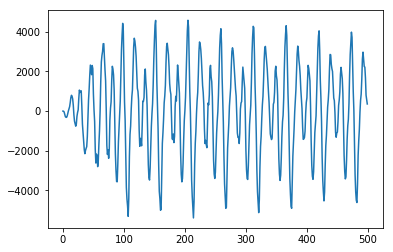

In [14]:
plt.plot(E_sht)

In [15]:
# Requires Interpolation because DPSS algorithm cannot give large sequence values
def DPSS_taper(arr, NW = 1):
    x = np.arange(0,10001)
    y = windows.dpss(10001, NW)
    f = sp.interpolate.interp1d(x, y)
    
    x_new = np.arange(0,10000,10000/len(arr))
    
    return arr*f(x_new)

def DPSS(arr, NW = 1):
    x = np.arange(0,10001)
    y = windows.dpss(10001, NW)
    f = sp.interpolate.interp1d(x, y)
    
    x_new = np.arange(0,10000,10000/len(arr))
    
    return f(x_new)

In [23]:
NW1 = 1; NW2 = 3; NW3 = 5; NW4 = 10
E_dpss1 = DPSS_taper(E_sht, NW=NW1)
E_dpss2 = DPSS_taper(E_sht, NW=NW2)
E_dpss3 = DPSS_taper(E_sht, NW=NW3)
E_dpss4 = DPSS_taper(E_sht, NW=NW4)

In [24]:
f_E, Pxx_den_E = signal.periodogram(E_sht, sr)
f_E_dpss1, Pxx_den_E_dpss1 = signal.periodogram(E_dpss1, sr)
f_E_dpss2, Pxx_den_E_dpss2 = signal.periodogram(E_dpss2, sr)
f_E_dpss3, Pxx_den_E_dpss3 = signal.periodogram(E_dpss3, sr)
f_E_dpss4, Pxx_den_E_dpss4 = signal.periodogram(E_dpss4, sr)

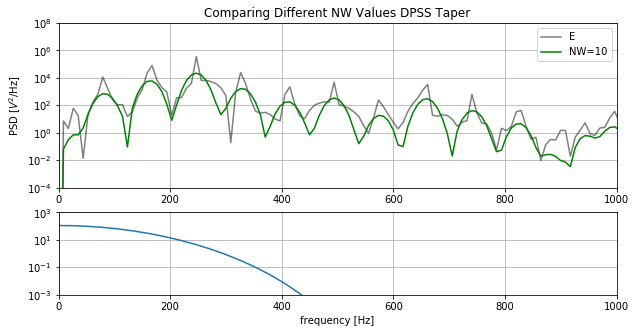

In [145]:
fig, (ax,axm) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1.5]}, figsize=(10,5))

ax.semilogy(f_E, Pxx_den_E, label='E', c='k', alpha=0.5)
ax.semilogy(f_E_dpss4, Pxx_den_E_dpss4,label='NW={}'.format(NW4), c='green')

f, h = freqz(DPSS(E_sht, NW=NW4)); w=w/(2*np.pi)
axm.semilogy(f*sr,np.abs(h))
axm.set_xlim(0,1000)
axm.set_ylim(10**-3, 1000)
axm.grid()
axm.set_xlabel('frequency [Hz]')


ax.set_ylabel('PSD [$V^2$/Hz]')
ax.set_xlim(0,1000)
ax.set_ylim(10**-4, 10**8) 
ax.legend() 
ax.grid()

ax.set_title('Comparing Different NW Values DPSS Taper')


plt.savefig('test_plot.png', dpi=300)
plt.show()

### Create an Animation

In [19]:
def animate(i, note, notename, FF):
    if i==0:
        global f_note; global Pxx_den_note
        f_note, Pxx_den_note = signal.periodogram(note, sr)
    
    NW = 0.5*i+1
    note_dpss = DPSS_taper(note, NW=NW)
    f_note_dpss, Pxx_den_note_dpss = signal.periodogram(note_dpss, sr)
    
    ax.clear()
    ax.semilogy(f_note, Pxx_den_note, label=notename, c='k', alpha=0.5)
    ax.semilogy(f_note_dpss, Pxx_den_note_dpss, label='NW=:{:.1f}'.format(NW), c='green')

    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('PSD [$V^2$/Hz]')
    ax.set_xlim(0,min(FF*10, max(f_note_dpss)))
    ax.set_ylim(10**-4, 10**8) 
    ax.legend() 
    ax.grid()

    ax.set_title('Comparing Different NW Values DPSS Taper')
    
    if NW > FF*np.pi*NN/sr:
        ax.set_facecolor('xkcd:salmon')

KeyboardInterrupt: 

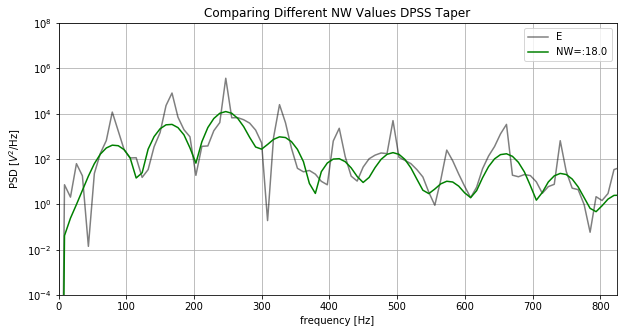

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
interval = 0.5#in seconds     
aniE = animation.FuncAnimation(fig,animate,200,interval=interval*1e+3,blit=False,
                             fargs=(E_sht, 'E', 82.4))
aniE.save('testvidE.mp4', fps=15)
plt.close()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
interval = 0.5#in seconds     
aniA = animation.FuncAnimation(fig,animate,200,interval=interval*1e+3,blit=False,
                             fargs=(A_sht, 'A', 110))
aniA.save('testvidA.mp4', fps=15)
plt.close()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
interval = 0.5#in seconds     
aniD = animation.FuncAnimation(fig,animate,200,interval=interval*1e+3,blit=False,
                             fargs=(D_sht, 'D', 146.8))
aniD.save('testvidD.mp4', fps=15)
plt.close()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
interval = 0.5#in seconds     
aniG = animation.FuncAnimation(fig,animate,200,interval=interval*1e+3,blit=False,
                             fargs=(G_sht, 'G', 196))
aniG.save('testvidG.mp4', fps=15)
plt.close()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
interval = 0.5#in seconds     
aniB = animation.FuncAnimation(fig,animate,200,interval=interval*1e+3,blit=False,
                             fargs=(B_sht, 'B', 246.94))
aniB.save('testvidB.mp4', fps=15)
plt.close()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
interval = 0.5#in seconds     
aniEh = animation.FuncAnimation(fig,animate,200,interval=interval*1e+3,blit=False,
                             fargs=(Eh_sht, 'Eh', 329.63))
aniEh.save('testvidEh.mp4', fps=15)
plt.close()

# Smoothing

We follow the instructions on pg 285 for computing the smoothed spectrum.

In [122]:
def get_periodogram(acvs):
    NN = len(acvs)
    
    acvs = np.concatenate((np.flip(acvs[1::]), acvs))
    S = np.fft.fft(acvs)
    freq = np.fft.fftfreq(len(S))
    return freq, S

In [123]:
E_tapered = DPSS_taper(E_sht, NW = 3)
st_D = statsmodels.tsa.stattools.acovf(E_sht, unbiased=False)
st_lw = sp.signal.parzen(len(st_D))*st_D
ff_D, S_D = get_periodogram(st_D)
S_lw = np.fft.fft(st_lw)

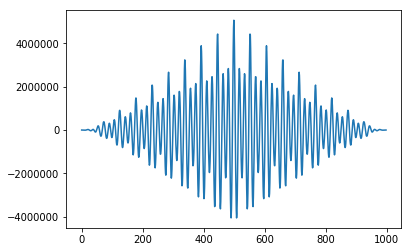

In [124]:
a = np.concatenate((np.flip(st_D[1::]), st_D))
plt.plot(a)

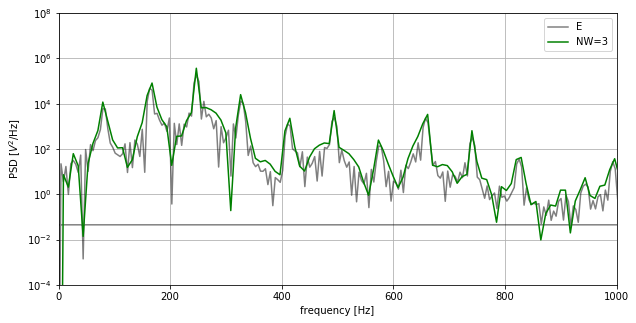

In [128]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.semilogy(ff_D*sr, np.abs(S_D)/(sr), label='E', c='k', alpha=0.5)
ax.semilogy(f_E, Pxx_den_E,label='NW={}'.format(NW2), c='green')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [$V^2$/Hz]')
ax.set_xlim(0,1000)
ax.set_ylim(10**-4, 10**8) 
ax.legend() 
ax.grid()

plt.show()

In [129]:
len(S_D)

999

In [130]:
len(Pxx_den_E)

251